# FX vol trading strategy - implementation

In [65]:
# Import libraries
import pandas as pd
import numpy as np
from data_cleaning.import_data import import_data
from utils.garch import get_rolling_vol_forecasts
from utils.plots import plot_trades, plot_grid_forecasted_vs_realized
from utils.statistics import forecasting_accuracy
from utils.trading_strategy import gen_trading_signals, calc_pnl
from arch import arch_model

import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
fx_pairs =[
    'USDRUB',
    'USDZAR',
    'USDBRL',
    'EURUSD',
    'USDJPY',
    'GBPUSD'
]
dfs = { pair : import_data(fx_pair=pair) for pair in fx_pairs }

## Forecast volatility

In [3]:
# generate volatility forecasts
for pair, df in dfs.items():
    return_series = dfs[pair].dropna()['log_ret'] * 100 
    model = arch_model(return_series, vol='GARCH', p=1, q=1, dist='Studentst')  # every pair gets a GARCH(1,1) cf. Lunde

    # Conditional volatility forecasting
    vol_forecasts = get_rolling_vol_forecasts(return_series=return_series,
                                                model = model, 
                                                horizon=21,
                                                fitting_end_date="2021-01-01",
                                                ) # rolling forecast to get sequential 21-days-ahead conditional volatility forecasts
    dfs[pair] = dfs[pair].merge(vol_forecasts['h.21'], left_index=True, right_index=True)
    dfs[pair].rename(columns={'h.21':'cond_vol_forecast'},inplace=True)
    dfs[pair]['cond_forecast_to_implied'] = dfs[pair]['cond_vol_forecast'] / dfs[pair]['v1m']


Fitting rolling GARCH(p: 1, q: 1) model with a Standardized Student's t distribution.
Number of forecasts: 277
.....................................................................................................................................................................................................................................................................................Fitting rolling GARCH(p: 1, q: 1) model with a Standardized Student's t distribution.
Number of forecasts: 277
.....................................................................................................................................................................................................................................................................................Fitting rolling GARCH(p: 1, q: 1) model with a Standardized Student's t distribution.
Number of forecasts: 277
.................................................................................................................

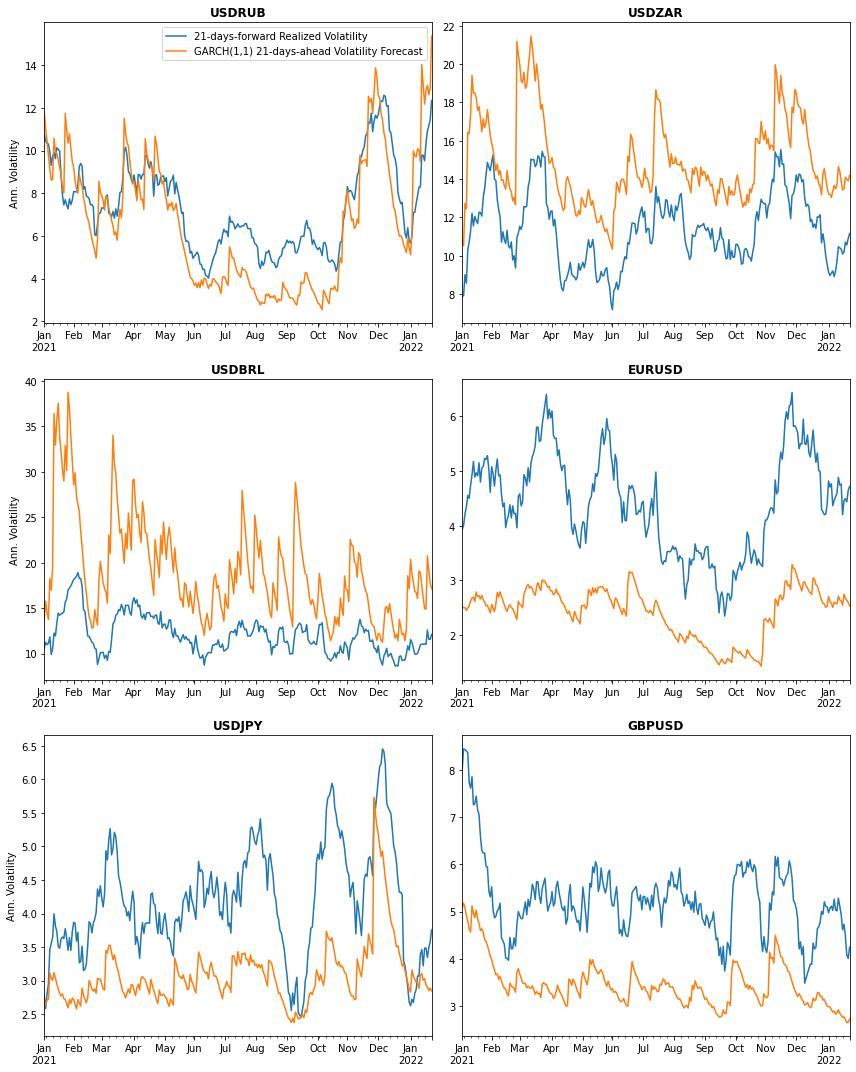

In [5]:
plot_grid_forecasted_vs_realized(df_dict=dfs, implied=False)

## Generate trading signals

We start by looking at 1 pair, e.g. USDRUB.

We can either hold to maturity (``days_holding_period`` $=21$) and get: 
$$ PnL = sign(direction) * (realized^{\ next \ 21 \ days} - implied^{\ now}) - 2 * spread $$

or we can close trade by going opposite direction after ``days_holding_period``$ = 0<x<21$ days and get:
$$ PnL = sign(direction) * (implied^{\ in \ x \ days} - implied^{\ now}) - 2 * spread $$


In [86]:
threshold_up = 1.1
threshold_down = 0.9
days_holding_period = 5 # 21
pair = 'USDBRL'
df = dfs[pair].copy(deep=True)

In [95]:
gen_trading_signals(df, thres_up=threshold_up,thres_down=threshold_down, days_holding_period = days_holding_period)
df.tail(10)

,v1m,v3m,v1y,px_last,px_bid,px_ask,log_ret,rolling_21d_realized_stdev,forward_rolling_21d_realized_stdev,normalized_bid_ask_spread,cond_vol_forecast,cond_forecast_to_implied,direction,gearing,v1m_close_trade,returns,returns_w_gearing,direction_flag
2022-01-11,15.343,15.495,17.198,5.5730,5.5726,5.5735,-0.017273,10.445824,9.522999,0.016149,19.091754,1.244330,1,1.244330,14.635,-0.740298,-0.913284,Bought straddle
2022-01-12,14.993,15.230,17.002,5.5203,5.5200,5.5205,-0.009501,10.984476,9.021069,0.009058,18.870094,1.258594,0,0.000000,14.555,-0.018115,-0.018115,nan
2022-01-13,14.575,15.095,16.938,5.5289,5.5282,5.5295,0.001557,11.046326,8.913476,0.023513,17.452278,1.197412,0,0.000000,14.577,-0.047026,-0.047026,nan
2022-01-14,14.330,14.997,16.763,5.5280,5.5276,5.5285,-0.000163,11.032044,9.335899,0.016281,16.136459,1.126061,0,0.000000,15.003,-0.032561,-0.032561,nan
2022-01-17,14.590,15.105,16.800,5.5230,5.5225,5.5235,-0.000905,11.081837,9.990822,0.018106,14.970510,1.026080,0,0.000000,16.605,-0.036212,-0.036212,nan
2022-01-18,14.635,14.930,16.807,5.5681,5.5675,5.5686,0.008133,11.009741,9.961798,0.019756,14.885680,1.017129,0,0.000000,NaN,NaN,NaN,nan
2022-01-19,14.555,14.900,16.802,5.4461,5.4455,5.4466,-0.022154,12.590954,8.880165,0.020198,20.740203,1.424954,1,1.424954,NaN,NaN,NaN,Bought straddle
2022-01-20,14.577,15.042,16.995,5.4372,5.4368,5.4375,-0.001636,11.593122,9.209715,0.012874,19.119747,1.311638,0,0.000000,NaN,NaN,NaN,nan
2022-01-21,15.003,15.267,17.110,5.4515,5.4510,5.4520,0.002627,11.566311,9.489284,0.018344,17.745897,1.182823,0,0.000000,NaN,NaN,NaN,nan
2022-01-24,16.605,16.415,17.530,5.4909,5.4904,5.4914,0.007201,12.110684,8.944912,0.018212,17.164642,1.033703,0,0.000000,NaN,NaN,NaN,nan


## How does the trades look?

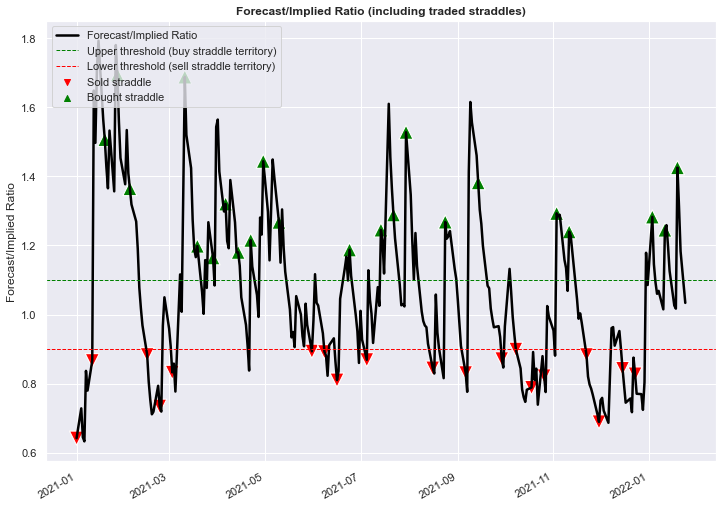

In [92]:
plot_trades(df=df,
            thres_up=threshold_up,
            thres_down=threshold_down, 
            #include_implied=True, 
            #include_forecasted=True,
            )

As can be seen from the graph, we are short vol the whole period due to the thresholds....

Normalized PnL: -11.05%
Normalized PnL w. Gearing: -13.94%


,direction,v1m,v1m_close_trade,forward_rolling_21d_realized_stdev,normalized_bid_ask_spread,gearing,returns,returns_w_gearing,normalized_pnl,normalized_pnl_w_gearing
2020-12-31,0,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-01,-1,21.290,21.767,18.152996,0.071175,1.357621,-0.619350,-0.789936,-0.006194,-0.007899
2021-01-11,-1,22.573,21.650,17.410117,0.018156,1.133537,0.886687,1.009942,0.002618,0.002120
2021-01-19,1,21.450,21.757,11.598764,0.029896,1.506569,0.247207,0.402724,0.005097,0.006156
2021-01-27,1,21.838,19.382,9.421976,0.020331,1.693785,-2.496661,-4.200596,-0.019997,-0.036108
2021-02-04,1,19.358,17.772,9.272624,0.022090,1.364392,-1.630180,-2.208106,-0.035973,-0.057392
2021-02-15,-1,17.245,18.682,14.336637,0.024174,1.116224,-1.485348,-1.652362,-0.050292,-0.072968
2021-02-23,-1,18.838,19.597,15.323711,0.014702,1.265240,-0.788404,-0.989721,-0.057779,-0.082143
2021-03-03,-1,20.560,20.645,16.144591,0.008892,1.167232,-0.102783,-0.116998,-0.058748,-0.083216
2021-03-11,1,20.160,19.928,13.903436,0.027077,1.687301,-0.286153,-0.445607,-0.061441,-0.087302


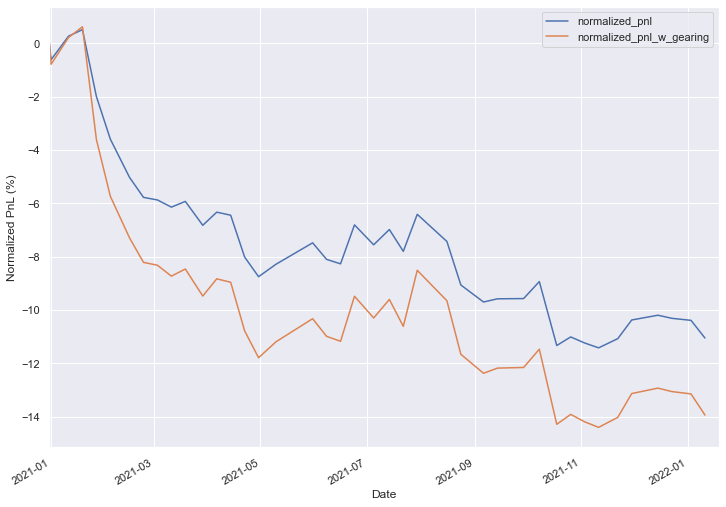

In [98]:
calc_pnl(df,plot=True)